In [1]:
# Created January 4, 2021
# Updated January 7, 2021

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
if True:
    mpl.rcParams['lines.linewidth'] = 0.75
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.05
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['xtick.major.pad'] = 2
    mpl.rcParams['xtick.minor.pad'] = 1.5
    mpl.rcParams['ytick.major.pad'] = 2
    mpl.rcParams['ytick.minor.pad'] = 1.5
    mpl.rcParams['figure.facecolor'] = (1,1,1,1) #white
    mpl.rcParams['figure.edgecolor'] = (1,1,1,1) #white
    mpl.rcParams['axes.titlesize'] = 10
    mpl.rcParams['legend.fontsize'] = 6
    mpl.rcParams['axes.labelpad'] = 0

import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

blues = mpl.cm.get_cmap('Blues')
reds = mpl.cm.get_cmap('Reds')

import methods.filter_lineages as fl
import pickle

In [28]:
# bac, bc = 'BtVPI', 'HL'
# norm = mpl.colors.LogNorm( 1, 3e3 )

# with open('muller_lineages.pkl', 'rb') as f:
#     muller_lineage_dict = pickle.load(f)

def plot_lfc_heat_map(ax, lfcs1, lfcs2, norm=None, binspace=None, cmap=blues, colorbar=True):
    where_finite = (lfcs1.mask + lfcs2.mask == 0)

    if not np.any(binspace):
        binspace = np.linspace(-1., 1, 41)

    density, binx, biny = np.histogram2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace)

    if not norm:
        norm = mpl.colors.LogNorm( 1, np.max(density) )

    ## plot empirical
    ax.hist2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace, cmap=cmap, norm=norm)


    if colorbar:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

def plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple,
                               norm=mpl.colors.LogNorm(0.1, 3e3),
                               colorbar=False, cmap=mpl.cm.Reds,
                               minfreq=10**-6.5, plot_muller=False):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple

    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > minfreq

    m1_reads1, m1_reads2 = fl.get_read_arrays(bac, m1, m1t1, m1t2, split_day0=2)
    m2_reads1, m2_reads2 = fl.get_read_arrays(bac, m2, m2t1, m2t2, split_day0=1)
    m1_D1, m1_D2 = m1_reads1.sum(), m1_reads2.sum()
    m2_D1, m2_D2 = m2_reads1.sum(), m2_reads2.sum()
    m1_freqs1, m1_freqs2 = m1_reads1 / m1_D1, m1_reads2 / m1_D2
    m2_freqs1, m2_freqs2 = m2_reads1 / m2_D1, m2_reads2 / m2_D2

    m1_f1, m1_f2 = fl.maxmin_freqs(m1_freqs1, m1_D1, m1_freqs2, m1_D2)
    m2_f1, m2_f2 = fl.maxmin_freqs(m2_freqs1, m2_D1, m2_freqs2, m2_D2)

    m1_lfcs = fl.calc_lfc_array( m1_f1, m1_f2, m1t2-m1t1)
    m2_lfcs = fl.calc_lfc_array( m2_f1, m2_f2, m2t2-m2t1)

    binspace = np.linspace(np.min([m1_lfcs,m2_lfcs]), np.max([m1_lfcs, m2_lfcs]), 41)
    # binspace = [ np.linspace(-np.log(1/epsilon)/dt1 -1/100, np.log(1/epsilon)/dt1 + 1/100, 41),
    #              np.linspace(-np.log(1/epsilon)/dt2 -1/100, np.log(1/epsilon)/dt2 + 1/100, 41)]

    plot_lfc_heat_map(ax, m1_lfcs[lineage_bool], m2_lfcs[lineage_bool], norm=norm, binspace=binspace, colorbar=colorbar, cmap=cmap)

    if plot_muller:
        for diet, marker in [('HF', (3,0,-90)), ('LF', (3,0,0)), ('HLH', (3,0,-45)), ('LHL', (3,0,-45))]:
            muller_lineages = muller_lineage_dict[bac][diet]


            m1_star_lfcs = m1_lfcs[muller_lineages]
            m2_star_lfcs = m2_lfcs[muller_lineages]

            ax.scatter(m1_star_lfcs, m2_star_lfcs, color=DIET_COLORS[diet], marker=marker, s=10, zorder=20)


with open('../figure1_muller_and_transition/10biggest_indices_v2.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


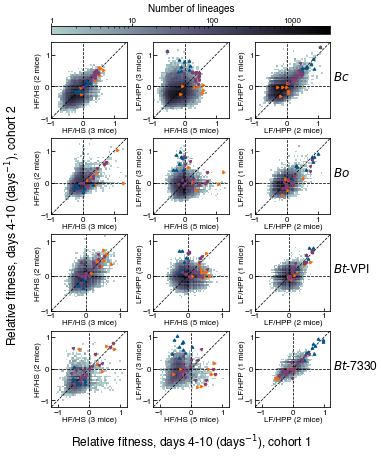

In [138]:
HF_mice, LF_mice = [DIET_MICE_MAP['HF'], DIET_MICE_MAP['LF']]
HLH_mice, LHL_mice = [DIET_MICE_MAP['HLH'], DIET_MICE_MAP['LHL']]
diet_names = {'HF':'HF/HS', 'LF':'LF/HPP'}

def savefig(fig, i):
    fig.savefig( f'{plot_dir}/presentation_figures/fig3_tradeoffs_v{i}.png' )
    return i+1
version = 1
### FIGURE 3 ###

fig = plt.figure(figsize=(5, 7))

outer = mpl.gridspec.GridSpec(nrows=8, ncols=5,
                              height_ratios=(0.1, 1, 0.05, 1, 0.05, 1, 0.05, 1),
                              width_ratios=(1, 0.1, 1, 0.1, 1))
outer_ax = fig.add_subplot(outer[1:, :])
outer_ax.set_xlabel('Relative fitness, days 4-10 (days$^{-1}$), cohort 1', fontsize=12, labelpad=17)
outer_ax.set_ylabel('Relative fitness, days 4-10 (days$^{-1}$), cohort 2', fontsize=12, labelpad=15)
ax_methods.turn_off_ax(outer_ax)

colorbar_ax = fig.add_subplot(outer[0, :])
norm = mpl.colors.LogNorm(0.1, 3e3)
_ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r,
                                ticklocation='top',
                                norm=norm,
                                orientation='horizontal')
colorbar_ax.tick_params(axis='both', direction='out', labelsize=8, pad=-1)
colorbar_ax.set_title('Number of lineages', fontsize=10)
colorbar_ax.set_xlim(1, 3*10**3)
colorbar_ax.set_xticks([1, 10, 100, 1000])
colorbar_ax.set_xticklabels(['1', '10', '100', '1000'])


for b, bac in enumerate(BACTERIA):
    bac_outer_ax = fig.add_subplot(outer[1+2*b, :])
    bac_outer_ax.text(1.01, 0.5, BAC_FORMAL_NAMES[bac], fontsize=12,
                      transform=bac_outer_ax.transAxes, horizontalalignment='left', weight='bold')
    ax_methods.turn_off_ax(bac_outer_ax)

    for c, (m1, m2) in enumerate([([6, 7, 8], [9, 10]), ([6, 7, 8, 9, 10], [16, 18, 19]), ([16, 18], [19])]):
        t0, t1 = 4, 10
        diet1, diet2 = mouse2diet[m1[0]], mouse2diet[m2[0]]
        xlabel = f'{diet1} {t0}-{t1}'
        ylabel = f'{diet2} {t0}-{t1}'

        m1_tuple = (m1, t0, t1)
        m2_tuple = (m2, t0, t1)

        ax = fig.add_subplot(outer[1+2*b, 2*c])
        if c == 1:
            muller=True
        else:
            muller=True
        plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple, colorbar=False, norm=norm, cmap=mpl.cm.bone_r, plot_muller=muller)
        # ax.text(0.1, 0.9, BAC_FORMAL_NAMES[bac], transform=ax.transAxes)
        ax.set_xlabel(f'{diet_names[diet1]} ({len(m1)} mice)')
        ax.set_ylabel(f'{diet_names[diet2]} ({len(m2)} mice)',  labelpad=-2)

        if bac == 'BWH2': min, max = -1.0, 1.4
        elif bac == 'BtVPI': min, max = -1.0, 1.2
        elif bac == 'Bovatus': min, max = -1.0, 1.4
        elif bac == 'Bt7330': min, max = -1.2, 1.2
        ax.set_xlim(min, max)
        ax.set_ylim(min, max)

        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dashed', color='black')
        ax.axvline(0, color='black', linestyle='dashed', zorder=5)
        ax.axhline(0, color='black', linestyle='dashed', zorder=5)

fig.savefig(f'{biorxiv}/SI_410_correlation_plots.pdf')
